In [95]:
import os
os.getcwd()

'd:\\Learning\\use_cases\\12.nlp\\nlp\\01.fake_news_detection\\src'

Importing the Fake News data with labels

In [96]:

from pathlib import Path
import numpy as np
import pandas as pd
import re
import string

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

import gensim

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split


pd.set_option("display.max_columns", None)
# pd.set_option('display.max_colwidth', 100)
stopwords = nltk.corpus.stopwords.words('english')

# Get current working directory (where you started Python/Jupyter)
cwd = Path.cwd()

# Go one level up from src/ to project root
project_root = cwd.parent

# Data folder path
data_dir = project_root / "data"

#Load the data
data = pd.read_csv(data_dir / "SMSSpamCollection.tsv", sep='\t') 
data.columns = ['label', 'body_text']

data.head()

,label,body_text
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...
1,ham,"Nah I don't think he goes to usf, he lives aro..."
2,ham,Even my brother is not like to speak with me. ...
3,ham,I HAVE A DATE ON SUNDAY WITH WILL!!
4,ham,As per your request 'Melle Melle (Oru Minnamin...


Custom Preprocessing Function

In [97]:
# Initialize reusable objects
STEMMER = PorterStemmer()
LEMMATIZER = WordNetLemmatizer()
TOKENIZER = RegexpTokenizer(r"\w+")
STOP_WORDS = stopwords

# ---------- INDIVIDUAL FUNCTIONS ---------- #

def remove_html_tags(text: str) -> str:
    """Remove HTML tags using regex."""
    return re.sub(r"<.*?>", "", text)

def remove_urls(text: str) -> str:
    """Remove URLs from the text."""
    return re.sub(r"http\S+|www\S+", "", text)

def remove_numbers(text: str) -> str:
    """Remove digits from the text."""
    return re.sub(r"\d+", "", text)

def remove_placeholders(text: str) -> str:
    """Remove XXXX placeholders."""
    return re.sub(r"\bX{2,}\b", "", text, flags=re.IGNORECASE)

def tokenize(text: str):
    """Tokenize text into words (alphanumeric only)."""
    return TOKENIZER.tokenize(text)

def remove_stopwords(tokens: list, stop_words=STOP_WORDS) -> list:
    """Remove stopwords and keep words with length > 2."""
    return [w for w in tokens if w not in stop_words and len(w) > 2]

def normalize(tokens: list, use_stemming: bool = True) -> list:
    """
    Normalize tokens using stemming or lemmatization.
    
    Parameters
    ----------
    tokens : list
        List of words to normalize.
    use_stemming : bool
        If True, apply PorterStemmer; otherwise, use WordNetLemmatizer.
    """
    if use_stemming:
        return [STEMMER.stem(w) for w in tokens]
    else:
        return [LEMMATIZER.lemmatize(w) for w in tokens]

# ---------- MAIN PIPELINE FUNCTION ---------- #

def preprocess_text(text: str, use_stemming: bool = True) -> dict:
    """
    Run full preprocessing pipeline on a single text.
    
    Parameters
    ----------
    text : str
        Raw input text.
    use_stemming : bool, optional (default=True)
        If True, applies stemming. If False, applies lemmatization.
        
    Returns
    -------
    dict
        Dictionary containing intermediate steps and final output.
    """
    text = str(text).lower().replace("{html}", "")
    
    clean_html = remove_html_tags(text)
    clean_url = remove_urls(clean_html)
    clean_num = remove_numbers(clean_url)
    clean_placeholder = remove_placeholders(clean_num)
    tokens = tokenize(clean_placeholder)
    filtered = remove_stopwords(tokens)
    normalized = normalize(filtered, use_stemming)
    
    return {
        "clean_html": clean_html,
        "clean_url": clean_url,
        "clean_num": clean_num,
        "tokens": tokens,
        "filtered": filtered,
        "normalized": normalized,
        "final_text": " ".join(normalized)
    }

def transform_dataframe(df: pd.DataFrame, text_col: str, use_stemming: bool = True) -> pd.DataFrame:
    """
    Apply preprocessing pipeline to a DataFrame column.
    Adds intermediate results as new columns.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with text data.
    text_col : str
        Column name containing raw text.
    use_stemming : bool, optional (default=True)
        If True, applies stemming. If False, applies lemmatization.
        
    Returns
    -------
    pd.DataFrame
        DataFrame with added preprocessing columns.
    """
    results = df[text_col].apply(lambda x: preprocess_text(x, use_stemming=use_stemming))
    result_df = pd.json_normalize(results)
    return pd.concat([df, result_df], axis=1)

# Use lemmatization instead of stemming
processed_df = transform_dataframe(data, text_col="body_text", use_stemming=False)

processed_df.head()


,label,body_text,clean_html,clean_url,clean_num,tokens,filtered,normalized,final_text
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry in a wkly comp to win fa cup final...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, cup, final, tkt...","[free, entry, wkly, comp, win, cup, final, tkt...",free entry wkly comp win cup final tkts may te...
1,ham,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...","[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, go, usf, life, around, though]",nah think go usf life around though
2,ham,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me. ...,even my brother is not like to speak with me. ...,even my brother is not like to speak with me. ...,"[even, my, brother, is, not, like, to, speak, ...","[even, brother, like, speak, treat, like, aids...","[even, brother, like, speak, treat, like, aid,...",even brother like speak treat like aid patent
3,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,i have a date on sunday with will!!,i have a date on sunday with will!!,i have a date on sunday with will!!,"[i, have, a, date, on, sunday, with, will]","[date, sunday]","[date, sunday]",date sunday
4,ham,As per your request 'Melle Melle (Oru Minnamin...,as per your request 'melle melle (oru minnamin...,as per your request 'melle melle (oru minnamin...,as per your request 'melle melle (oru minnamin...,"[as, per, your, request, melle, melle, oru, mi...","[per, request, melle, melle, oru, minnaminungi...","[per, request, melle, melle, oru, minnaminungi...",per request melle melle oru minnaminunginte nu...


### Apply BoW

In [98]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(max_features=2000)
X_bow = count_vect.fit_transform(processed_df['final_text']).toarray()
print(X_bow.shape)

print(count_vect.get_feature_names_out())

(5567, 2000)
['aathi' 'abi' 'abiola' ... 'yuo' 'yup' 'zed']


### Adding certain Features

In [99]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['body_text'].apply(lambda x: count_punct(x))

X_features = pd.concat([data['body_len'], data['punct%'], pd.DataFrame(X_bow,columns = count_vect.get_feature_names_out())], axis=1)
X_features.columns = X_features.columns.astype(str)


### Model Random Forest and Grdient Boost Classifier

In [ ]:

def evaluate_estimators(X, y):
    """
    Train and evaluate RandomForestClassifier and GradientBoostingClassifier with hyperparameters.
    Print results in a structured format.
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # RandomForestClassifier hyperparameters
    rf_params = {
        "n_estimators": [10, 50, 100],
        "max_depth": [10, 20, 30, None]
    }

    # GradientBoostingClassifier hyperparameters
    gb_params = {
        "n_estimators": [50, 100, 150],
        "max_depth": [3, 7, 11],
        "learning_rate": [0.01, 0.1, 1]
    }

    # Evaluate RandomForestClassifier
    print("==================")
    print("RandomForest Results")
    print("==================")
    for n_est in rf_params["n_estimators"]:
        for depth in rf_params["max_depth"]:
            rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, n_jobs=-1, random_state=42)
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)
            precision, recall, fscore, _ = score(y_test, y_pred, average='binary', pos_label='spam')
            print(f"n_estimators: {n_est}, max_depth: {depth} -> Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {fscore:.3f}")
            

    # # Evaluate GradientBoostingClassifier
    # print("\n==================")
    # print("GradientBoosting Results")
    # print("==================")
    # for n_est in gb_params["n_estimators"]:
    #     for depth in gb_params["max_depth"]:
    #         for lr in gb_params["learning_rate"]:
    #             gb = GradientBoostingClassifier(n_estimators=n_est, max_depth=depth, learning_rate=lr, random_state=42)
    #             gb.fit(X_train, y_train)
    #             y_pred = gb.predict(X_test)
    #             precision, recall, fscore, _ = score(y_test, y_pred, average='binary', pos_label='spam')
    #             print(f"n_estimators: {n_est}, max_depth: {depth}, learning_rate: {lr} -> Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {fscore:.3f}")

# Example usage:
# Assuming `X_features` is your feature matrix and `data['label']` is your target variable
evaluate_estimators(X_features, data['label'])

RandomForest Results
n_estimators: 10, max_depth: 10 -> Precision: 1.000, Recall: 0.265, F1-Score: 0.419
n_estimators: 10, max_depth: 20 -> Precision: 1.000, Recall: 0.667, F1-Score: 0.800
n_estimators: 10, max_depth: 30 -> Precision: 1.000, Recall: 0.796, F1-Score: 0.886
n_estimators: 10, max_depth: None -> Precision: 0.993, Recall: 0.905, F1-Score: 0.947
n_estimators: 50, max_depth: 10 -> Precision: 1.000, Recall: 0.259, F1-Score: 0.411
n_estimators: 50, max_depth: 20 -> Precision: 1.000, Recall: 0.701, F1-Score: 0.824
n_estimators: 50, max_depth: 30 -> Precision: 1.000, Recall: 0.823, F1-Score: 0.903
n_estimators: 50, max_depth: None -> Precision: 1.000, Recall: 0.912, F1-Score: 0.954
n_estimators: 100, max_depth: 10 -> Precision: 1.000, Recall: 0.347, F1-Score: 0.515
n_estimators: 100, max_depth: 20 -> Precision: 1.000, Recall: 0.673, F1-Score: 0.805
n_estimators: 100, max_depth: 30 -> Precision: 1.000, Recall: 0.830, F1-Score: 0.907
n_estimators: 100, max_depth: None -> Precision:

### Feature Importance Plot - Placeholder

C:\Users\SUMAN\AppData\Local\Temp\ipykernel_25156\1328016925.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_50_features, palette='viridis')


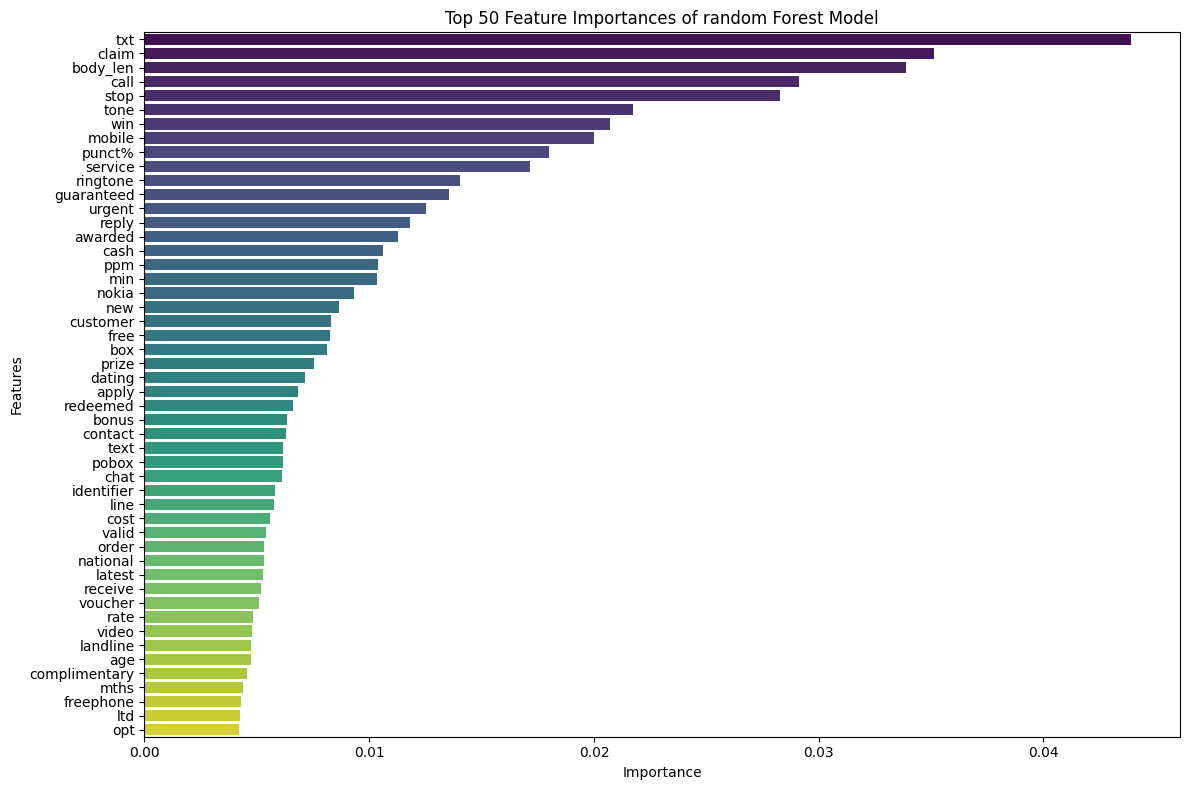

Top 50 Feature Importances with their values:
            feature  importance
4686            txt    0.043880
540           claim    0.035129
0          body_len    0.033887
428            call    0.029139
4396           stop    0.028299
4619           tone    0.021716
4891            win    0.020706
2792         mobile    0.020024
1            punct%    0.017992
4167        service    0.017171
4041       ringtone    0.014047
1567     guaranteed    0.013557
4734         urgent    0.012535
3968          reply    0.011835
219         awarded    0.011283
471            cash    0.010601
3589            ppm    0.010372
2735            min    0.010366
3048          nokia    0.009338
2999            new    0.008648
692        customer    0.008315
1289           free    0.008238
357             box    0.008129
3671          prize    0.007538
715          dating    0.007161
158           apply    0.006844
3897       redeemed    0.006623
337           bonus    0.006364
622         contact    0.0

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# feature_importances = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': rf.feature_importances_
# }).sort_values('importance', ascending=False)

# # Get top 50 most important features
# top_50_features = feature_importances.head(50)

# # Visualize the results
# plt.figure(figsize=(12, 8))
# sns.barplot(x='importance', y='feature', data=top_50_features, palette='viridis')
# plt.title('Top 50 Feature Importances of random Forest Model')
# plt.xlabel('Importance')
# plt.ylabel('Features')
# plt.tight_layout()
# plt.show()

# # Print numerical values
# print("Top 50 Feature Importances with their values:")
# print(top_50_features)

# # Additional statistics
# print(f"\nFeature Importance Statistics:")
# print(f"Total features: {len(feature_importances)}")
# print(f"Top feature importance: {top_50_features.iloc[0]['importance']:.4f}")
# print(f"Cumulative importance of top 50: {top_50_features['importance'].sum():.4f}")
# print(f"Percentage of total importance (top 50): {(top_50_features['importance'].sum() / feature_importances['importance'].sum() * 100):.2f}%")


### Word2Vec

In [86]:
### Lets train Word2vec from scratch
import gensim
model=gensim.models.Word2Vec(processed_df['normalized'],vector_size = 500,window=5,min_count=2,sg=0,compute_loss=True,epochs=10)

In [93]:
# Average word2vec
def avg_word2vec(doc, model):
    vectors = [model.wv[word] for word in doc if word in model.wv.index_to_key]
    if len(vectors) == 0:
        # return zero vector if no words are in vocabulary
        return np.zeros(model.vector_size)  
    return np.mean(vectors, axis=0)

# Apply avg_word2vec
X_w2v = processed_df['normalized'].apply(lambda x: avg_word2vec(x, model))
# Convert to 2D numpy array
X_w2v = np.vstack(X_w2v.values)
# Convert back to DataFrame if you want column names
X_w2v = pd.DataFrame(X_w2v, columns=[f'vec_{i}' for i in range(X_w2v.shape[1])])
print(X_w2v.head())


      vec_0     vec_1     vec_2     vec_3     vec_4     vec_5     vec_6  \
0  0.106304  0.203775  0.230875  0.203774 -0.076453 -0.218255  0.039949   
1  0.139632  0.189490  0.219567  0.165434 -0.053552 -0.229922  0.035690   
2  0.147336  0.206128  0.237808  0.182306 -0.059807 -0.244477  0.038028   
3  0.082807  0.123288  0.142996  0.112960 -0.038818 -0.142002  0.022985   
4  0.082970  0.131446  0.150099  0.124206 -0.043280 -0.150646  0.025665   

      vec_7     vec_8     vec_9    vec_10    vec_11    vec_12    vec_13  \
0  0.288315  0.101949  0.015812 -0.038103  0.034215  0.029541 -0.010396   
1  0.275058  0.102616  0.006813 -0.027858  0.065240  0.014911 -0.004754   
2  0.300538  0.112373  0.008877 -0.032578  0.064971  0.016193 -0.007842   
3  0.179082  0.065060  0.006701 -0.021043  0.033640  0.012977 -0.004567   
4  0.191773  0.070756  0.006765 -0.023516  0.033235  0.012602 -0.004731   

     vec_14    vec_15    vec_16    vec_17    vec_18    vec_19    vec_20  \
0  0.118622 -0.194303 -

In [100]:
X_features_w2v = pd.concat([data['body_len'], data['punct%'], X_w2v], axis=1)


### Model Random Forest and Grdient Boost Classifier (Word2Vec)

In [103]:

def evaluate_estimators(X, y):
    """
    Train and evaluate RandomForestClassifier and GradientBoostingClassifier with hyperparameters.
    Print results in a structured format.
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # RandomForestClassifier hyperparameters
    rf_params = {
        "n_estimators": [10, 50, 100],
        "max_depth": [10, 20, 30, None]
    }

    # GradientBoostingClassifier hyperparameters
    gb_params = {
        "n_estimators": [50, 100, 150],
        "max_depth": [3, 7, 11],
        "learning_rate": [0.01, 0.1, 1]
    }

    # Evaluate RandomForestClassifier
    print("==================")
    print("RandomForest Results")
    print("==================")
    for n_est in rf_params["n_estimators"]:
        for depth in rf_params["max_depth"]:
            rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, n_jobs=-1, random_state=42)
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)
            precision, recall, fscore, _ = score(y_test, y_pred, average='binary', pos_label='spam')
            print(f"n_estimators: {n_est}, max_depth: {depth} -> Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {fscore:.3f}")
            

    # # Evaluate GradientBoostingClassifier
    # print("\n==================")
    # print("GradientBoosting Results")
    # print("==================")
    # for n_est in gb_params["n_estimators"]:
    #     for depth in gb_params["max_depth"]:
    #         for lr in gb_params["learning_rate"]:
    #             gb = GradientBoostingClassifier(n_estimators=n_est, max_depth=depth, learning_rate=lr, random_state=42)
    #             gb.fit(X_train, y_train)
    #             y_pred = gb.predict(X_test)
    #             precision, recall, fscore, _ = score(y_test, y_pred, average='binary', pos_label='spam')
    #             print(f"n_estimators: {n_est}, max_depth: {depth}, learning_rate: {lr} -> Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {fscore:.3f}")

# Example usage:
# Assuming `X_features` is your feature matrix and `data['label']` is your target variable
evaluate_estimators(X_features_w2v, data['label'])

RandomForest Results
n_estimators: 10, max_depth: 10 -> Precision: 0.874, Recall: 0.898, F1-Score: 0.886
n_estimators: 10, max_depth: 20 -> Precision: 0.891, Recall: 0.891, F1-Score: 0.891
n_estimators: 10, max_depth: 30 -> Precision: 0.891, Recall: 0.891, F1-Score: 0.891
n_estimators: 10, max_depth: None -> Precision: 0.891, Recall: 0.891, F1-Score: 0.891
n_estimators: 50, max_depth: 10 -> Precision: 0.870, Recall: 0.912, F1-Score: 0.890
n_estimators: 50, max_depth: 20 -> Precision: 0.893, Recall: 0.905, F1-Score: 0.899
n_estimators: 50, max_depth: 30 -> Precision: 0.893, Recall: 0.905, F1-Score: 0.899
n_estimators: 50, max_depth: None -> Precision: 0.893, Recall: 0.905, F1-Score: 0.899
n_estimators: 100, max_depth: 10 -> Precision: 0.865, Recall: 0.912, F1-Score: 0.887
n_estimators: 100, max_depth: 20 -> Precision: 0.875, Recall: 0.905, F1-Score: 0.890
n_estimators: 100, max_depth: 30 -> Precision: 0.875, Recall: 0.905, F1-Score: 0.890
n_estimators: 100, max_depth: None -> Precision: